<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/lung/glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of Glaucoma**

## **Introduction**

Glaucoma is marked by the dysfunction and loss of retinal ganglion cells (RGCs), leading to structural changes in the optic nerve head, retinal nerve fiber layer (RNFL) thickness, ganglion cell layer, inner plexiform layers, and loss of the visual field. Early diagnosis is crucial to prevent significant vision loss, but it is challenging, especially in myopic eyes and patients with brain diseases due to the characteristic disc shape and visual field defects.

This work is based on data from Kim SJ et al. (2017). Development of machine learning models for diagnosis of glaucoma.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)

## **Load Data and Preprocess Data**

In [14]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
import fileinput
filePath ="/content/gdrive/MyDrive/lung/ds_whole.csv"

In [16]:
import pandas as pd
data = pd.read_csv(filePath)

In [17]:
data.head(3)

,RL,glaucoma,age,ocular_pressure,MD,PSD,GHT,cornea_thickness,RNFL4.mean
0,OD,0,62,17,-0.54,1.81,0,558,103.333333
1,OS,0,62,17,-0.64,1.38,0,564,107.666667
2,OD,0,66,12,-1.65,2.89,2,490,162.000000


In [18]:
data['glaucoma'].value_counts()

glaucoma
1    297
0    202
Name: count, dtype: int64

In [19]:
# RL:  "OD" and "OS" refer to the right and left eyes, respectively
columns_to_remove = ['RL']
data = data.drop(columns=columns_to_remove)

In [20]:
data.head(2)

,glaucoma,age,ocular_pressure,MD,PSD,GHT,cornea_thickness,RNFL4.mean
0,0,62,17,-0.54,1.81,0,558,103.333333
1,0,62,17,-0.64,1.38,0,564,107.666667


In [21]:
data.isnull().sum(axis=0)


glaucoma            0
age                 0
ocular_pressure     0
MD                  0
PSD                 0
GHT                 0
cornea_thickness    0
RNFL4.mean          0
dtype: int64

In [41]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [23]:
X.shape

(499, 7)

## **Clustering by KMeans**

To assess if the current features are sufficient allow the segregation of clusters (gluacoma vs normal), I perform cluster analysis using KMeans.

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

inertias_1 = []
silhouette_avgs = []
max_K = 5
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

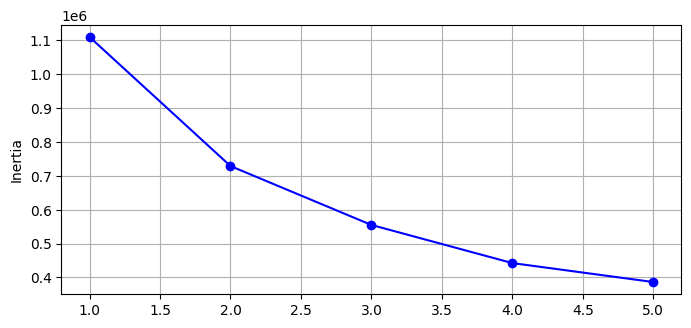

In [25]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 6), inertias_1, "bo-")
plt.xlabel("")
plt.ylabel("Inertia")
plt.grid()
plt.show()

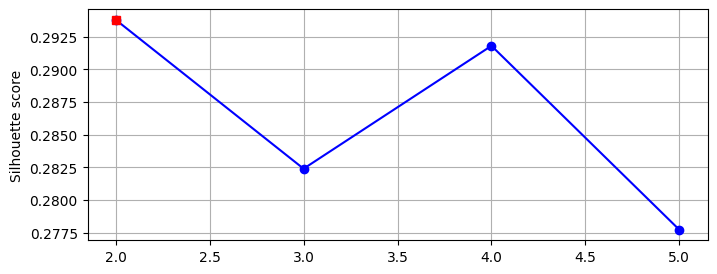

In [26]:
plt.figure(figsize=(8, 3))

k_range = range(2, 6)
best_index = np.argmax(silhouette_avgs)
best_k = k_range[best_index]
best_score = silhouette_avgs[best_index]

plt.plot(k_range, silhouette_avgs, "bo-")
plt.xlabel("")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

The optimial cluster is clusters based on Silhouette Score.

In [27]:
# using 2 clusters using all of the data
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
cluster_labels = kmeans.labels_

# Initialize dictionaries to store indices of data points belonging to each cluster
cluster_indices = {}
for i in range(2):  # Assuming 2 clusters
    cluster_indices[i] = []

for i, label in enumerate(cluster_labels):
    cluster_indices[label].append(y[i])


In [30]:
from collections import Counter

for key, value in cluster_indices.items():
    freq = Counter(value)
    print(key, ':', freq)


0 : Counter({0: 152, 1: 123})
1 : Counter({1: 174, 0: 50})


In [31]:
# using PCA to visualize the two clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
labels = kmeans.labels_

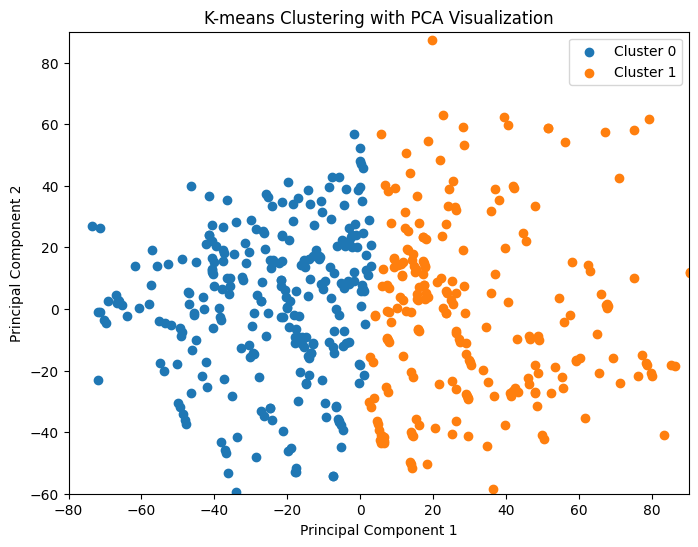

In [35]:

plt.figure(figsize=(8, 6))
x_range = (-80, 90)
y_range = (-60, 90)

for cluster_label in np.unique(labels):
    plt.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], label=f'Cluster {cluster_label}')

plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.show()

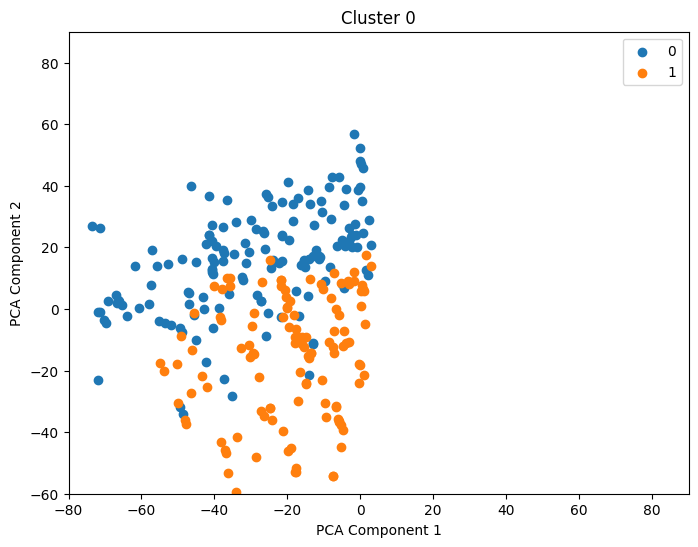

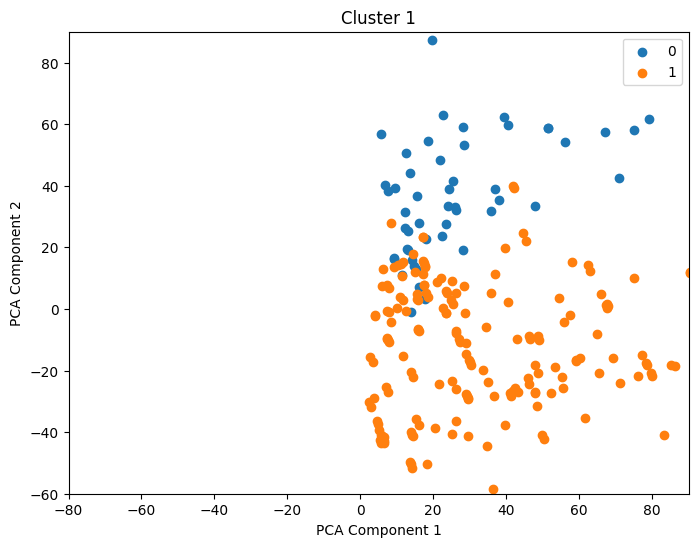

In [37]:
x_range = (-80, 90)
y_range = (-60, 90)

unique_labels = np.unique(kmeans.labels_)

for label in unique_labels:
    plt.figure(figsize=(8, 6))
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Cluster {label}')

    indices = np.where(kmeans.labels_ == label)

    for class_label in np.unique(data['glaucoma']):
        class_indices = np.where(data['glaucoma'].values[indices] == class_label)
        plt.scatter(X_pca[indices][class_indices, 0], X_pca[indices][class_indices, 1], label=f'{class_label}')
        print()

    plt.legend()
    plt.show()


Conclusion: Using KMean Clustering, there are optimually 2 clusters as assess by the Silhouette Score. Both Clusters compromise a mixture of glaucoma and non-glaucoma samples.

## **Classification**

I will use three difference approaches to try to classify Glaucoma with the aforementioned features. I will compare performance of Logistic Regression, SVC, and RandomForest Classifier. For each approach, I will determine the optimal parameters by grid_search.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   glaucoma          499 non-null    int64  
 1   age               499 non-null    int64  
 2   ocular_pressure   499 non-null    int64  
 3   MD                499 non-null    float64
 4   PSD               499 non-null    float64
 5   GHT               499 non-null    int64  
 6   cornea_thickness  499 non-null    int64  
 7   RNFL4.mean        499 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 31.3 KB


In [39]:
# Check if any cell contains NaN
any_nan = data.isna().any().any()
any_nan

False

In [43]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
X_train.shape, y_test.shape

((399, 7), (100,))

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight

cv = 5

## **Logistic Regression**

In [47]:
from sklearn.linear_model import LogisticRegression

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

log_reg = LogisticRegression(class_weight=dict(zip(np.unique(y_train), class_weights)), max_iter=5000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.05, 0.1],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 1.2314814814814814,
                                                        1: 0.8417721518987342},
                                          max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.05, 0.1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [48]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
log_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(log_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Mean Cross-Validation Score: 0.9072468354430381


In [49]:
y_pred = log_best_model.predict(X_test)

In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[38,  2],
       [ 9, 51]])

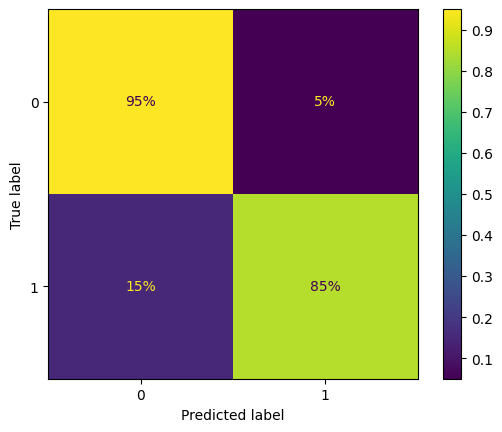

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87        40
           1       0.96      0.85      0.90        60

    accuracy                           0.89       100
   macro avg       0.89      0.90      0.89       100
weighted avg       0.90      0.89      0.89       100



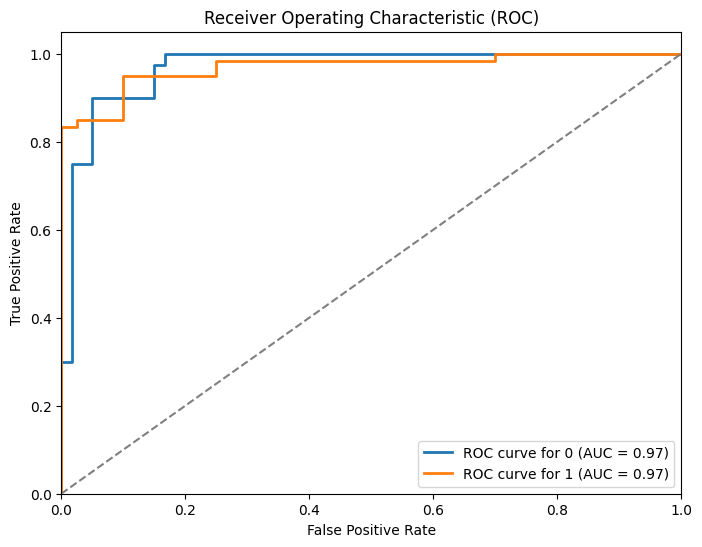

In [55]:
from sklearn.metrics import roc_curve, auc

## auc
y_prob = log_best_model.predict_proba(X_test)

class_labels = [0, 1]

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


## **SVC**

In [56]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
}

grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [57]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

svc_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(svc_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 10, 'gamma': 1}
Mean Cross-Validation Score: 0.9323101265822785


In [58]:
y_pred = svc_best_model.predict(X_test)

In [59]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[36,  4],
       [ 1, 59]])

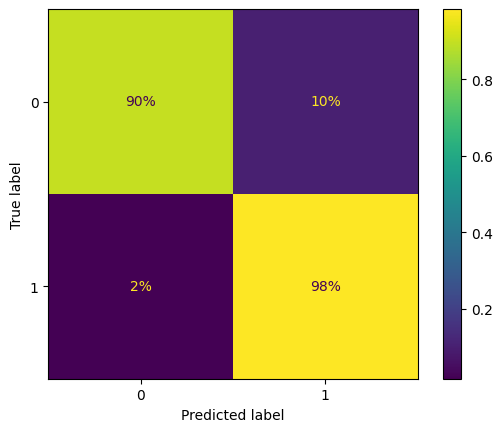

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94        40
           1       0.94      0.98      0.96        60

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100



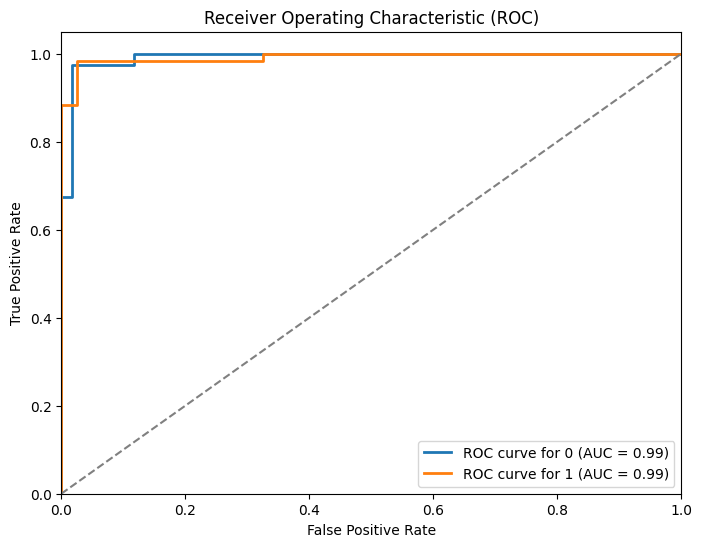

In [62]:
## auc

y_prob = svc_best_model.predict_proba(X_test)

class_labels = [0, 1]

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## **RandomForest**

In [63]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500, 800],  # Number of trees in the forest
    'max_depth': [None, 10, 20],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4, 8],     # Minimum number of samples required at each leaf node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 500, 800]},
             scoring='accuracy')

In [64]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

rf_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Mean Cross-Validation Score: 0.9498734177215189


In [65]:
y_pred = rf_best_model.predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[36,  4],
       [ 4, 56]])

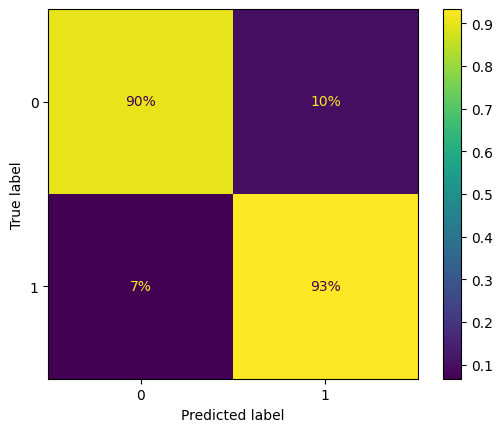

In [67]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [69]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        40
           1       0.93      0.93      0.93        60

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



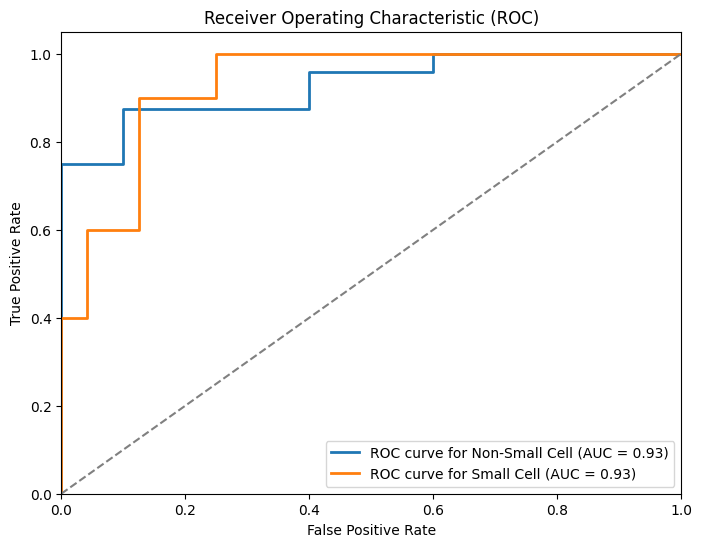

In [ ]:
## auc

y_prob = rf_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

I chose three different approaches, Logistic Regression, RandomForest, and SVC.,the best approach seems to be SVC and RandomForest as reported by Kim et al., with F1 score for Healthy and Glaucoma cases as 0.94 and 0.96, respectively, when using SVC. For RandomForest, the F1 scores are 0.9 and 0.93, respectively.

I use Voting Classifier to see if performance can be improved.

## Voting Classifier

In [81]:
from sklearn.base import clone

svc_model = SVC(probability=True, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

In [82]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('svc', svc_model), ('rf', rf_model)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

In [83]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[36,  4],
       [ 6, 54]])

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.93      0.90      0.92        60

    accuracy                           0.90       100
   macro avg       0.89      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



Using Voting Classifier did not improve classification performance.

## **Analysis of Predictive Features**

Next, I perform deeper analysis of feature that are important for segregating the two classes of samples. First I ask how many features accounts for 90% of the prediction using the RandomForest Model.

In [85]:
importances = rf_best_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Cumulative sum of feature importances
cumulative_importances = np.cumsum(importances[sorted_indices])

# Find the number of features that account for 90% of prediction
num_features_90_percent = np.argmax(cumulative_importances >= 0.9) + 1

print("Of the 7 features, how many of these accounting for 90% of prediction:", num_features_90_percent)


Of the 7 features, how many of these accounting for 90% of prediction: 5


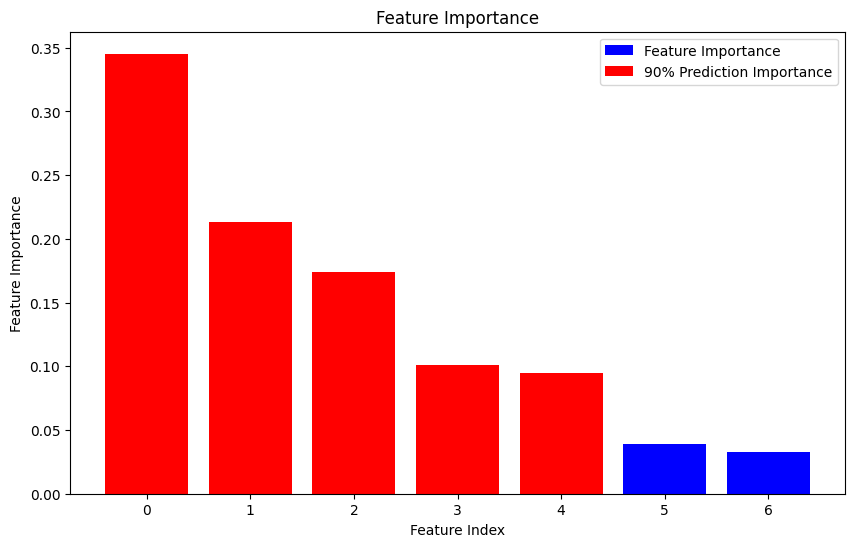

In [87]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align='center', color='blue', label='Feature Importance')

# Highlight the features that account for 90% of prediction
plt.bar(range(num_features_90_percent), importances[sorted_indices][:num_features_90_percent],
        align='center', color='red', label='90% Prediction Importance')

plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()


In [88]:
feature_order_by_importance = importances[sorted_indices]
feature_order_by_importance

array([0.34531581, 0.21350293, 0.17371683, 0.10072426, 0.09468896,
       0.03918764, 0.03286357])

In [89]:
X.columns[sorted_indices]

Index(['RNFL4.mean', 'PSD', 'MD', 'ocular_pressure', 'GHT', 'age',
       'cornea_thickness'],
      dtype='object')

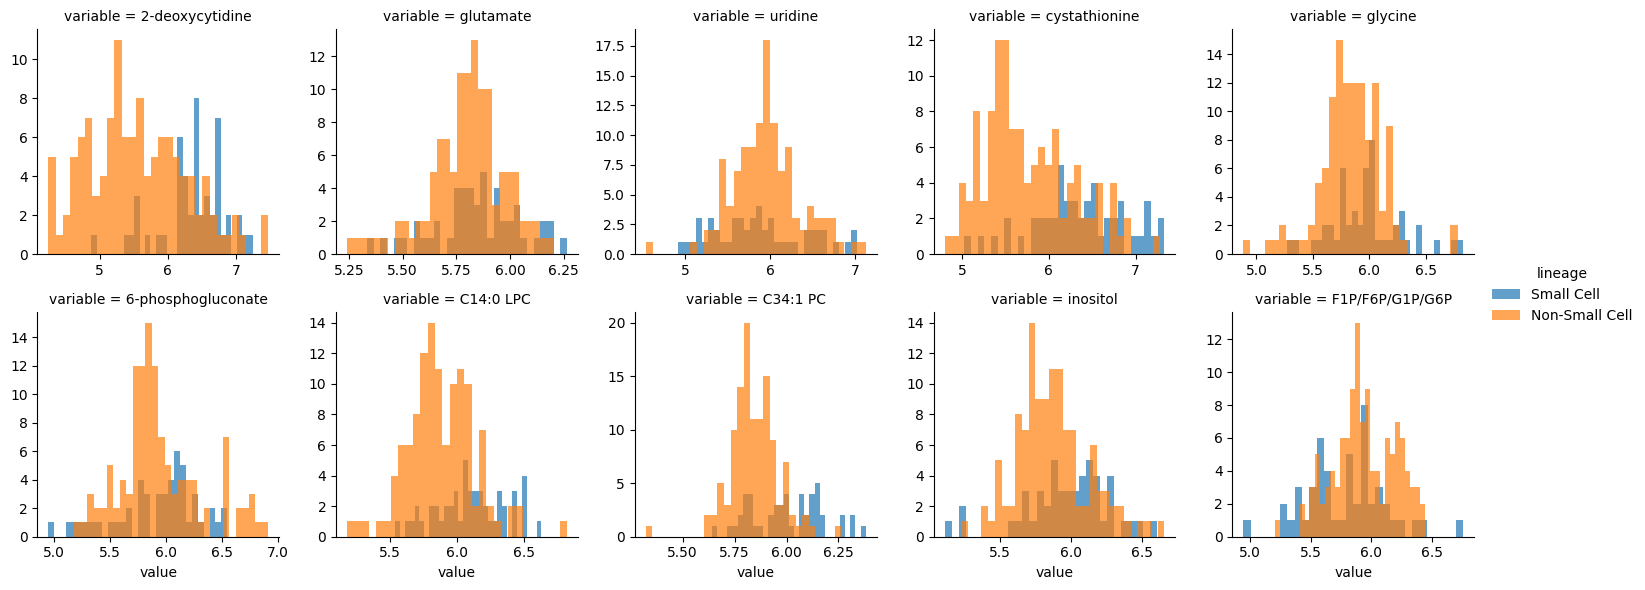

In [ ]:
import seaborn as sns

# Select top 10 features
top_10_indices = sorted(range(len(coefficients)), key=lambda i: abs(coefficients[i]), reverse=True)[:10]
top_10_features = [data.columns[i] for i in top_10_indices]

data_melted = pd.melt(data, id_vars='lineage', value_vars=top_10_features)

# Plot histograms using FacetGrid
g = sns.FacetGrid(data_melted, col='variable', hue='lineage', col_wrap=5, sharex=False, sharey=False)
g.map(plt.hist, 'value', bins=30, alpha=0.7)
g.add_legend()
plt.show()

Using the histogram for the top 10 features, the difference between Small Cell and Non-Small Cell Lung Cancer is often non-obvious. However, several metabolites, such as 2-Deoxycytidine and Cystathionine, are markedly higher in Small Cell Lung Cancer Cell lines.

## **Conclusion**

This work shows it is possible to classify Human Small Cell and Non-Small Cell Lung Cancer cells using metabolomic profiles. Interestingly, histogram of top 10 features show only small difference between these two types of cell lines. Further investigation needs to further elucidating these difference in metabolites play critical roles in tumor initition and pregression. This work, together with my previous work on the classification of Small Cell and Non-Small Cell Lung Cancer using miRNA expression [1] and Chromatin Profiles [2] highlight the distinct characteristic of these two Lung diseases.

[1] https://www.kaggle.com/code/gchan357/classification-of-human-lung-cancers

[2] https://www.kaggle.com/code/gchan357/lung-cancer-classification-chromatin-profiles

### Addendum

I explore if neural network classification will perform better than the approaches above.

In [ ]:
import sys
assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
y_train = y_train.apply(lambda x: 0 if x == "Non-Small Cell" else 1)
y_test = y_test.apply(lambda x: 0 if x == "Non-Small Cell" else 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [ ]:
X_train.shape

(136, 225)

In [ ]:
model = Sequential()

model.add(Dense(units=225,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=40,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=["accuracy"])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
model.fit(x=X_train,
          y=y_train,
          epochs=100,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
5/5 [==============================] - 2s 60ms/step - loss: 0.6489 - accuracy: 0.6985 - val_loss: 0.5953 - val_accuracy: 0.7059
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5920 - accuracy: 0.7059 - val_loss: 0.5963 - val_accuracy: 0.7059
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5838 - accuracy: 0.7059 - val_loss: 0.5524 - val_accuracy: 0.7059
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.5478 - accuracy: 0.7059 - val_loss: 0.5334 - val_accuracy: 0.7059
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5208 - accuracy: 0.7132 - val_loss: 0.5219 - val_accuracy: 0.7059
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 0.5196 - accuracy: 0.7206 - val_loss: 0.4878 - val_accuracy: 0.7059
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4842 - accuracy: 0.7132 - val_loss: 0.4702 - val_accuracy: 0.8529
Epoch 8/100
5/5 [===

<Axes: >

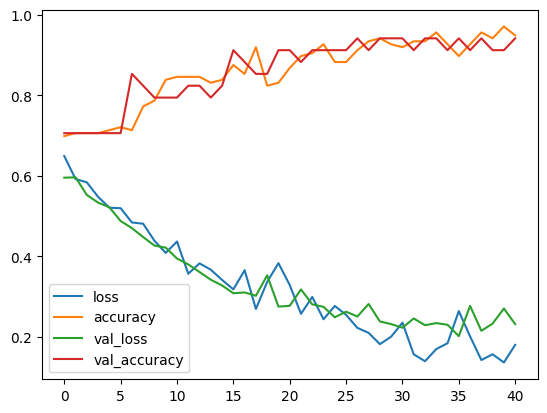

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

2/2 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.90      0.90      0.90        10

    accuracy                           0.94        34
   macro avg       0.93      0.93      0.93        34
weighted avg       0.94      0.94      0.94        34



Neural Network with the current configuration does not provide any improvement in classification performance compare to Logistic Regression.